In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
#Importing library
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.layers.normalization import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback
from keras import models
import numpy as np
#from utils import *
history = History()
leaky_relu_alpha = 0.3

In [ ]:
#Instantiation
input_shape=(512,512,3)
AlexNet = Sequential()
 
#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
 
 
#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
 
 
#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
 
#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
 
#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name="convpool_5"))
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
 
 
#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(2048))
#AlexNet.add(BatchNormalization())
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.5))
#AlexNet.add(BatchNormalization())
 
#2nd Fully Connected Layer
AlexNet.add(Dense(2048))
#AlexNet.add(BatchNormalization())
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.5))
#AlexNet.add(BatchNormalization())
 
#3rd Fully Connected Layer
AlexNet.add(Dense(1024))
#AlexNet.add(BatchNormalization())
#AlexNet.add(LeakyReLU(alpha=leaky_relu_alpha))
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.5))
 
#Output Layer
AlexNet.add(Dense(2))
#AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

In [ ]:
AlexNet.summary()

In [ ]:
batch_size_tr = 32
batch_size_val = 32
input_size = (512,512,3)

train_datagen = ImageDataGenerator(
        shear_range=0,
        zoom_range=0,
        featurewise_center=False,	# set input mean to 0 over dataset
        samplewise_center=False,	# set each sample mean to 0
        featurewise_std_normalization=False,	# divide inputs by std of dataset
        samplewise_std_normalization=False,	#divide each input by its std
        zca_whitening=False,	# apply ZCA whitening
        rotation_range=90,	# randomly roate images in the range (degrees, 0 to 180)
        width_shift_range=0,	# randomly shift image horizontally (fraction of width)
        height_shift_range=0,	# randomly shift image vertically (fraction of height)
        horizontal_flip=True,	# randomly flip images horizontally
        vertical_flip=True	# randomly flip images vertically
        )

test_datagen = ImageDataGenerator()
                                  

train_generator = train_datagen.flow_from_directory(
        '/mydrive/Fold_1/train',  
        batch_size=batch_size_tr,
        shuffle=True,
        target_size=(512,512),
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/mydrive/Fold_1/validation',  
        batch_size=batch_size_val,
        target_size=(512,512),
        shuffle=True,
        class_mode='categorical')

Found 82 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt

def append_history(history, h):
     '''
	This function appends the statistics over epochs
     '''
     try:
       history.history['loss'] = history.history['loss'] + h.history['loss']
       history.history['val_loss'] = history.history['val_loss'] + h.history['val_loss']
       history.history['accuracy'] = history.history['accuracy'] + h.history['accuracy']
       history.history['val_accuracy'] = history.history['val_accuracy'] + h.history['val_accuracy']
     except:
       history = h
                
     return history
            

def unfreeze_layer_onwards(model, layer_name):
    '''
        This layer unfreezes all layers beyond layer_name
    '''
    trainable = False
    for layer in model.layers:
        try:
            if layer.name == layer_name:
                trainable = True
            layer.trainable = trainable
        except:
            continue
    
    return model
            

def plot_performance(history):
    '''
	This function plots the train & test accuracy, loss plots
    '''
        
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.axis([0, 2000, 0.2, 0.8])
    plt.title('Accuracy v/s Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.axis([0, 2000, 0,1])
    plt.title('Loss v/s Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.tight_layout()
    plt.show()

In [ ]:
AlexNet.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/mydrive/Fold_1/checkpoints/cp-{epoch:04d}.ckpt"
#checkpoint_path = "/mydrive/Fold_1/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Dynamically varying the LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                              patience=3, min_lr=1e-6)

#Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

#Saving the best model
checkpointer = ModelCheckpoint(filepath="/mydrive/Fold_1/best_weights1.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1000)

# Create a new model instance
#model = create_model()
logs = Callback()
csv_logger = CSVLogger('/mydrive/Fold_1/training.log',append=True)

class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    print("End epoch {} of training; got log keys: {}".format(epoch, keys))


# Define the Keras TensorBoard callback.
logdir="logs/fit/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# Save the weights using the `checkpoint_path` format
AlexNet.save_weights(checkpoint_path.format(epoch=0))

history = AlexNet.fit_generator(train_generator,
                                #steps_per_epoch=train_generator.samples/train_generator.batch_size,
                                epochs=2000,
                                validation_data=validation_generator,
                                #validation_steps = validation_generator.samples/validation_generator.batch_size,
                                #nb_val_samples=800,
                                #initial_epoch = 1000,
                                verbose=1,                                 
                                callbacks=[cp_callback, tensorboard_callback, csv_logger, checkpointer,early_stopping])

np.save('/mydrive/Fold_1/my_history_512x512_3.npy',history.history)

Epoch 1/2000
3/3 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9024
Epoch 00001: val_accuracy improved from -inf to 0.64286, saving model to /mydrive/Fold_1/best_weights1.hdf5
3/3 [==============================] - 9s 3s/step - loss: 0.2304 - accuracy: 0.9024 - val_loss: 0.6112 - val_accuracy: 0.6429
Epoch 2/2000
3/3 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.7805
Epoch 00002: val_accuracy improved from 0.64286 to 0.67857, saving model to /mydrive/Fold_1/best_weights1.hdf5
3/3 [==============================] - 16s 5s/step - loss: 0.4806 - accuracy: 0.7805 - val_loss: 0.7856 - val_accuracy: 0.6786
Epoch 3/2000
3/3 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8780
Epoch 00003: val_accuracy improved from 0.67857 to 0.75000, saving model to /mydrive/Fold_1/best_weights1.hdf5
3/3 [==============================] - 19s 6s/step - loss: 0.2855 - accuracy: 0.8780 - val_loss: 0.4057 - val_accuracy: 0.7500
Epoch 4/

In [ ]:
plot_performance(history)

In [ ]:
import numpy as np
history1=np.load('/mydrive/Fold_1/my_history_512x512_1.npy',allow_pickle='TRUE').item()

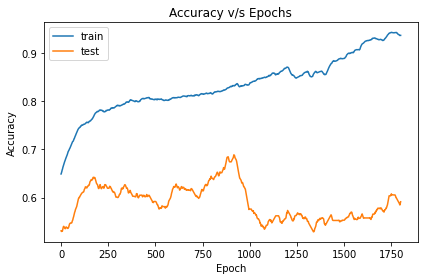

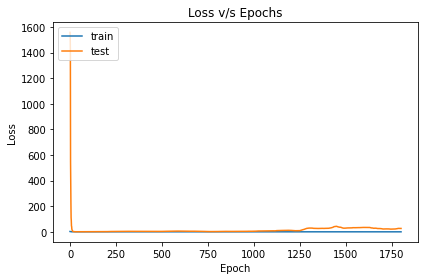

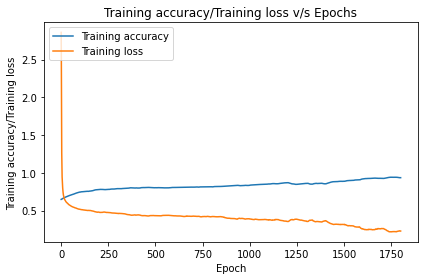

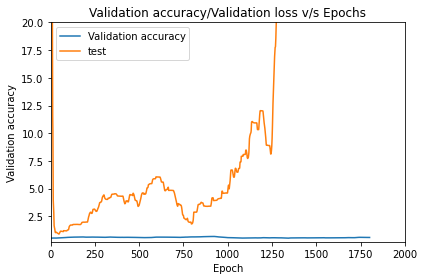

In [ ]:
history1['accuracy'] = np.convolve(history1['accuracy'], np.ones((n,)) / n, mode = "valid")
history1['val_accuracy'] = np.convolve(history1['val_accuracy'], np.ones((n,)) / n, mode = "valid")
history1['loss'] = np.convolve(history1['loss'], np.ones((n,)) / n, mode = "valid")
history1['val_loss'] = np.convolve(history1['val_loss'], np.ones((n,)) / n, mode = "valid")
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()


plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()


plt.plot(history1['accuracy'])
plt.plot(history1['loss'])
plt.title('Training accuracy/Training loss v/s Epochs')
plt.ylabel('Training accuracy/Training loss')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Training loss'], loc='upper left')
plt.tight_layout()
plt.show()


plt.plot(history1['val_accuracy'])
plt.plot(history1['val_loss'])
plt.axis([0, 2000, 0.2,20])
plt.title('Validation accuracy/Validation loss v/s Epochs')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation accuracy', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

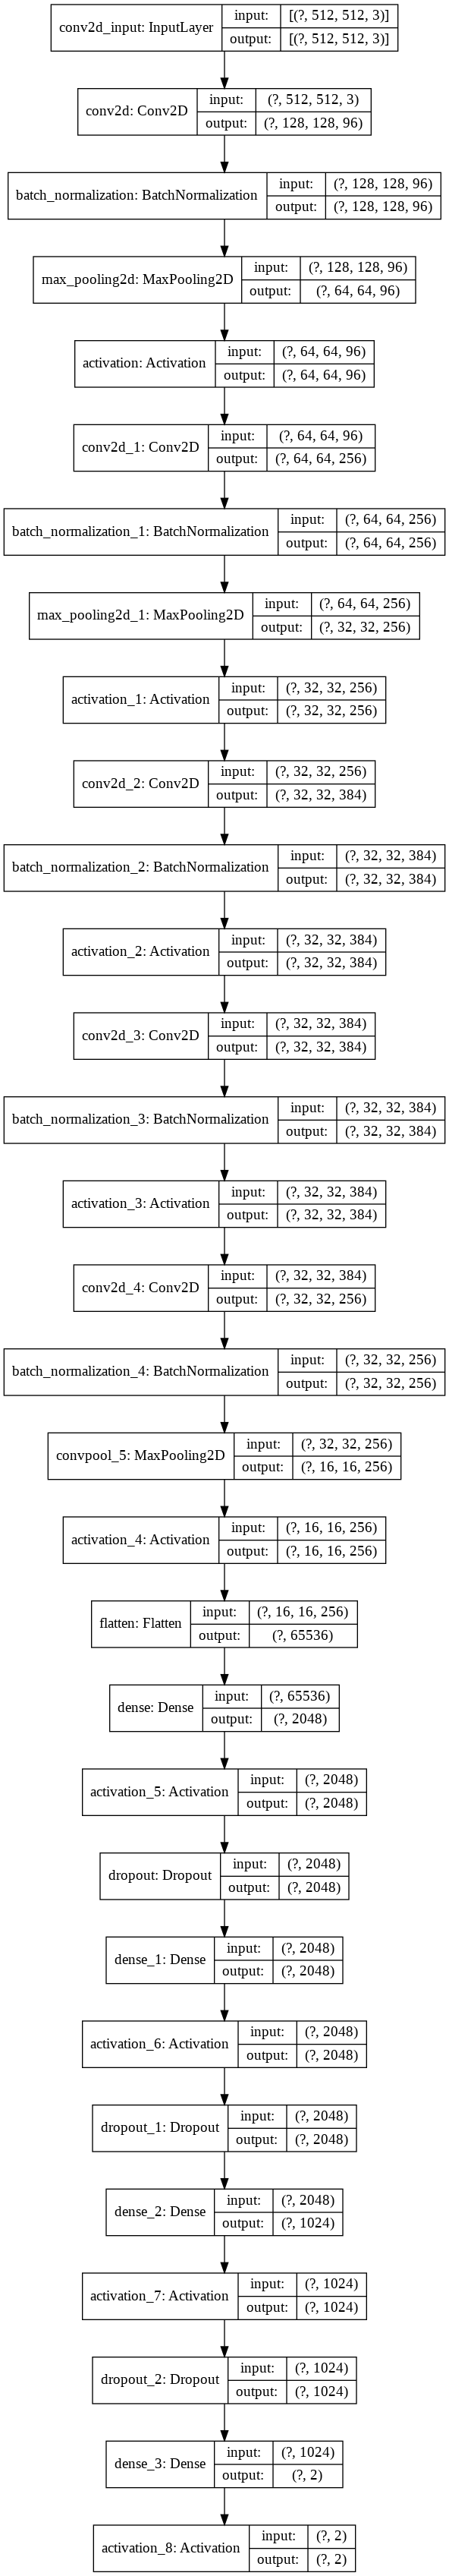

In [ ]:
keras.utils.plot_model(AlexNet, show_shapes=True)

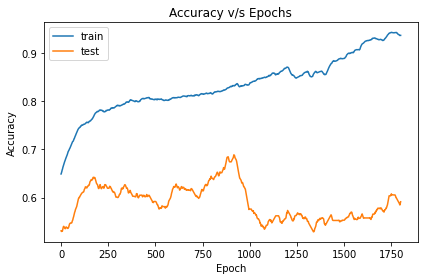

In [ ]:
n = 200
history.history['accuracy'] = np.convolve(history.history['accuracy'], np.ones((n,)) / n, mode = "valid")
plt.plot(history.history['accuracy'])
history.history['val_accuracy'] = np.convolve(history.history['val_accuracy'], np.ones((n,)) / n, mode = "valid")
plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()


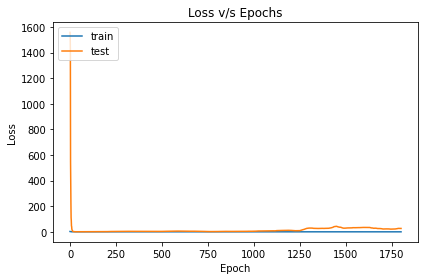

In [ ]:
n = 200
history.history['loss'] = np.convolve(history.history['loss'], np.ones((n,)) / n, mode = "valid")
plt.plot(history.history['loss'])
history.history['val_loss'] = np.convolve(history.history['val_loss'], np.ones((n,)) / n, mode = "valid")
plt.plot(history.history['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
AlexNet = tf.keras.models.load_model("/mydrive/Fold_1/model_v1_92.h5")

In [ ]:
AlexNet.save_weights("/mydrive/Fold_1/model_weights_v1_92.h5")

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/mydrive/Fold_1/checkpoints/cp-{epoch:04d}.ckpt"
#checkpoint_path = "/mydrive/Fold_1/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/mydrive/Fold_1/checkpoints/cp-0000.ckpt'

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/mydrive/Fold_1/checkpoints/cp-{epoch:04d}.ckpt"
#checkpoint_path = "/mydrive/Fold_1/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
AlexNet.load_weights("/mydrive/Fold_1/model_weights_v1_92.h5")


In [ ]:
datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(
        '/mydrive/Fold_1/test',  
        batch_size=32,
        target_size=(512,512),
        shuffle=True,
        class_mode='categorical')

Found 28 images belonging to 2 classes.


In [ ]:
AlexNet.evaluate(test_generator)

1/1 [==============================] - 0s 2ms/step - loss: 2.0308 - accuracy: 0.9286


[2.030778408050537, 0.9285714030265808]

In [ ]:
import numpy
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = AlexNet.predict_generator(test_generator, steps=1)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

In [ ]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

    negative       0.53      0.50      0.52        16
    positive       0.38      0.42      0.40        12

    accuracy                           0.46        28
   macro avg       0.46      0.46      0.46        28
weighted avg       0.47      0.46      0.47        28



In [ ]:
layers = ['dense_3','dense_2','dense_1','conv2d_4','conv2d_3','conv2d_2','conv2d_1','conv2d']
eb_epochs = [40,40,40,40,40,40,40,40]
lr = [1e-2,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3]

history_finetune = []

for i,layer in enumerate(layers):
        
    AlexNet = unfreeze_layer_onwards(AlexNet,layer)    
   
    AlexNet.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=1e-6),metrics=['accuracy'])
    
    for epoch in range(eb_epochs[i]):    
        h = AlexNet.fit_generator(train_generator,
                                        #samples_per_epoch=2000,
                                        validation_data=validation_generator,
                                        #nb_val_samples=800,
                                        epochs=1,
                                        verbose=1)
        
        history_finetune = append_history(history_finetune,h)

Instructions for updating:
Please use Model.fit, which supports generators.
3/3 [==============================] - 3s 1s/step - loss: 0.8313 - accuracy: 0.5976 - val_loss: 2.0408 - val_accuracy: 0.4286


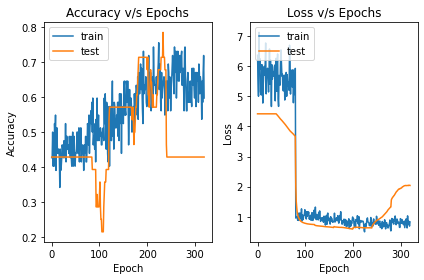

In [ ]:
plot_performance(history_finetune)

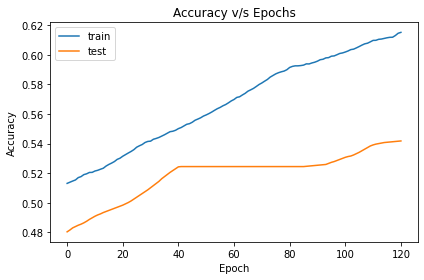

In [ ]:
n = 200
history_finetune.history['accuracy'] = np.convolve(history_finetune.history['accuracy'], np.ones((n,)) / n, mode = "valid")
plt.plot(history_finetune.history['accuracy'])
history_finetune.history['val_accuracy'] = np.convolve(history_finetune.history['val_accuracy'], np.ones((n,)) / n, mode = "valid")
plt.plot(history_finetune.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()

TIP: This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit Enter

function ClickConnect(){ console.log("Working"); document.querySelector("colab-toolbar-button#connect").click() } setInterval(ClickConnect,60000)

(1, 512, 512, 3)


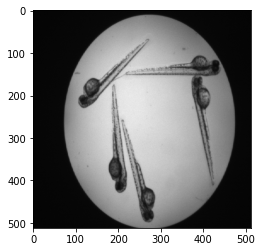

In [ ]:
image_path = "/mydrive/Fold_1/test/positive/straight_3.png"
# Pre-processing the image 
img = image.load_img(image_path, target_size = (512, 512)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis = 0) 
img_tensor = img_tensor / 255.
  
# Print image tensor shape 
print(img_tensor.shape) 
  
# Print image 
import matplotlib.pyplot as plt 
plt.imshow(img_tensor[0]) 
plt.show()

In [ ]:
# Outputs of the 8 layers, which include conv2D and max pooling layers 
layer_outputs = [layer.output for layer in AlexNet.layers[:8]] 
activation_model = models.Model(inputs = AlexNet.input, outputs = layer_outputs) 
activations = activation_model.predict(img_tensor) 
  
# Getting Activations of first layer 
first_layer_activation = activations[0] 
  
# shape of first layer activation 
print(first_layer_activation.shape) 
  
# 6th channel of the image after first layer of convolution is applied 
plt.matshow(first_layer_activation[0, :, :, 6], cmap ='viridis') 
  
# 15th channel of the image after first layer of convolution is applied 
plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')

In [ ]:
layer_names = [] 
  
for layer in AlexNet.layers[:30]: 
  layer_names.append(layer.name) 
print(layer_names) 

['conv2d_5', 'batch_normalization_5', 'max_pooling2d_3', 'activation_1', 'conv2d_6', 'batch_normalization_6', 'max_pooling2d_4', 'activation_2', 'conv2d_7', 'batch_normalization_7', 'activation_3', 'conv2d_8', 'batch_normalization_8', 'activation_4', 'conv2d_9', 'batch_normalization_9', 'max_pooling2d_5', 'activation_5', 'flatten_1', 'dense_3', 'activation_6', 'dense_4', 'activation_7', 'dropout_1', 'dense_5', 'activation_8']


In [ ]:
layer_names = []
for layer in AlexNet.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 32

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
## Now Predict
from os import listdir
from os.path import isfile, join
predict_dir_path='/mydrive/Fold_1/pred/pred/'
onlyfiles = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]
print(onlyfiles)

['bent_21.png', 'straight_31.png', 'straight_32.png', 'bent_46.png', 'bent_10.png', 'bent_28.png', 'straight_33.png', 'bent_70.png', 'bent_51.png', 'straight_3.png', 'straight_57.png', 'bent_38.png', 'bent_56.png', 'straight_13.png', 'straight_6.png', 'bent_7.png', 'straight_36.png', 'bent_1.png', 'bent_18.png', 'straight_21.png', 'bent_22.png', 'straight_27.png', 'straight_11.png', 'bent_71.png', 'straight_46.png', 'bent_73.png', 'bent_19.png', 'bent_66.png']


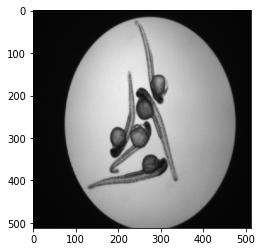

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
bent_21.png: negative


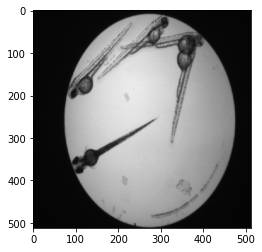

straight_31.png: positive


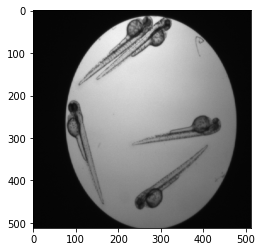

straight_32.png: positive


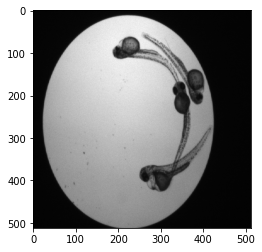

bent_46.png: negative


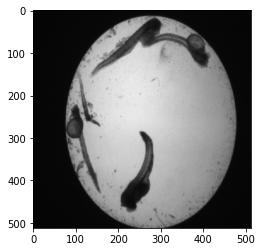

bent_10.png: positive


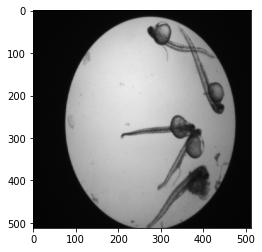

bent_28.png: negative


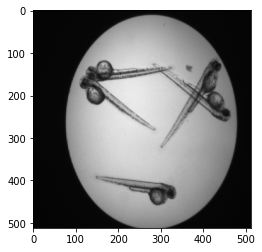

straight_33.png: positive


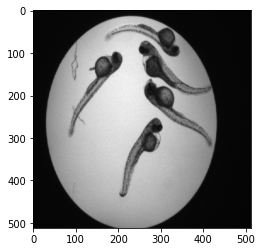

bent_70.png: negative


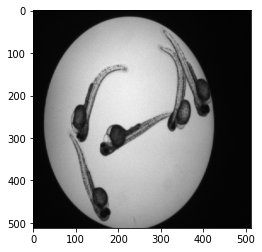

bent_51.png: negative


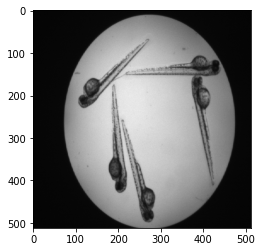

straight_3.png: positive


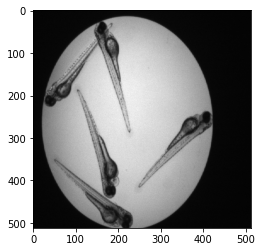

straight_57.png: positive


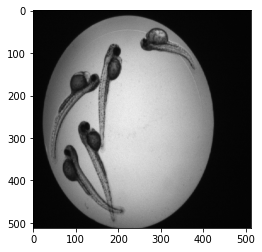

bent_38.png: negative


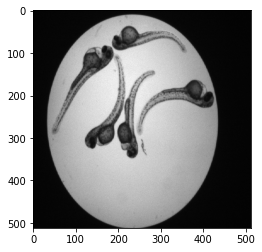

bent_56.png: negative


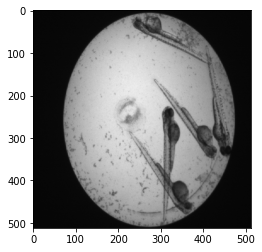

straight_13.png: positive


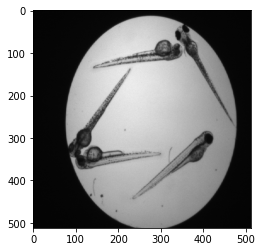

straight_6.png: positive


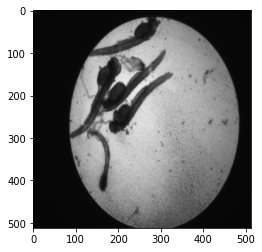

bent_7.png: negative


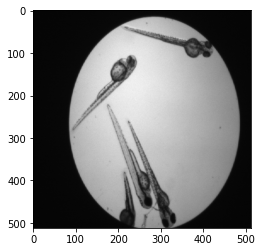

straight_36.png: positive


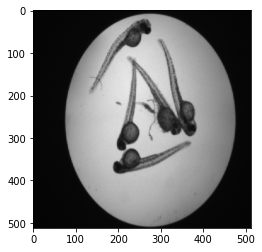

bent_1.png: negative


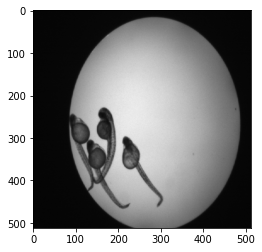

bent_18.png: negative


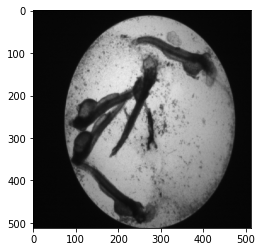

straight_21.png: negative


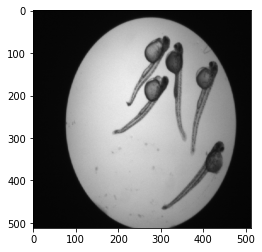

bent_22.png: positive


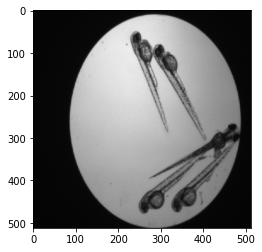

straight_27.png: positive


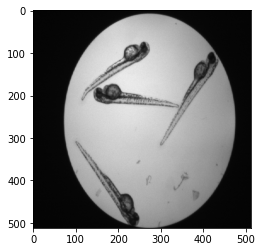

straight_11.png: positive


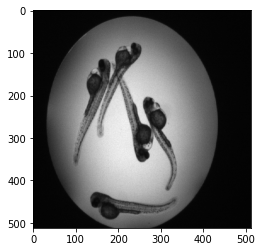

bent_71.png: negative


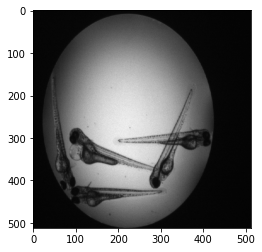

straight_46.png: positive


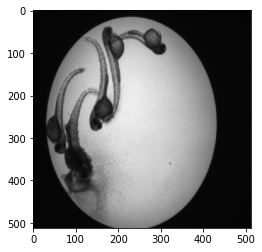

bent_73.png: negative


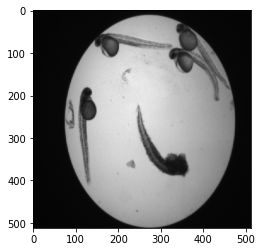

bent_19.png: negative


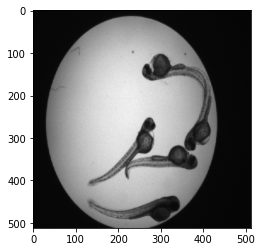

bent_66.png: negative
Total negative/bent fishes : 15
Total positive/normal fishes : 13


In [ ]:
# predicting images
from keras.preprocessing import image
neg_counter = 0 
pos_counter  = 0
fig=plt.figure()
for file in onlyfiles:
    img = image.load_img(predict_dir_path+file, target_size=(512, 512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #plt.subplot(4, 7, len(onlyfiles))
    #fig.add_subplot(4, 7, len(onlyfiles))
    plt.imshow(img)
    plt.show()
    
    images = np.vstack([x])
    classes = AlexNet.predict_classes(images, batch_size=32)
    #classes = classes[0][0]
    
    if classes == 0:
        print(file + ": " + 'negative')
        neg_counter += 1
    else:
        print(file + ": " + 'positive')
        pos_counter += 1

print("Total negative/bent fishes :",neg_counter)
print("Total positive/normal fishes :",pos_counter)